<a href="https://colab.research.google.com/github/aashu-0/learn-pytorch/blob/main/01_pytorch_device_agnostic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# replicating the same that in 01pytorch.ipymb but this time writing device agnostic code
# device agnostic code means --> if there's gpu avaliable then use it, if not then by default cpu


In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.4.1+cu121'

In [3]:
# setting the device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using device: {device}')

Using device: cuda


In [4]:
# data creation
# creating known paramas
weight = 0.7
bias = 0.3

#create data
X= torch.arange(0,1,0.02)    #features
X = X.unsqueeze(dim=1)       #labels
y = weight*X +bias

len(X), X[:10], y[:10]

(50,
 tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
#train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[: train_split], y[: train_split]
X_test, y_test = X[train_split: ], y[train_split :]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

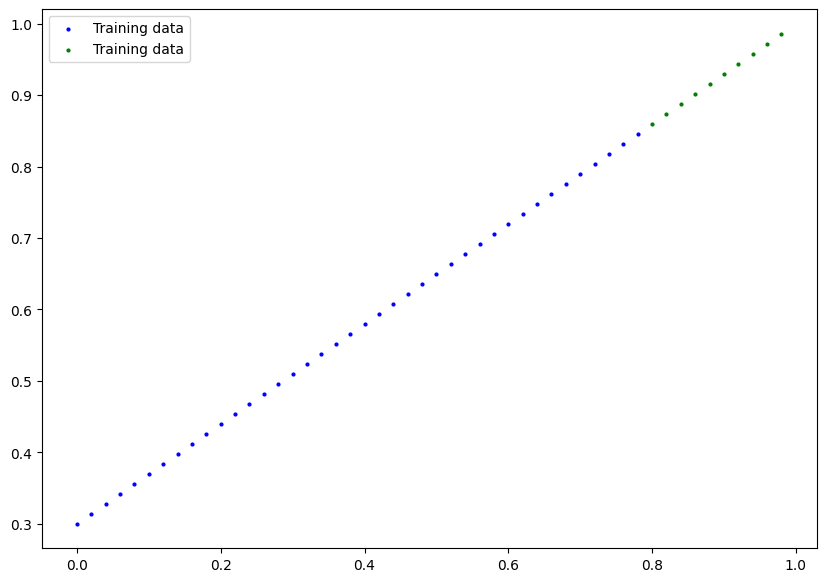

In [6]:
# visualizing the trainig and test set

def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None
                     ):
  plt.figure(figsize = (10,7))

  #training data in blue
  plt.scatter(train_data, train_labels, s=4, c='b', label= 'Training data')

  # test data in green
  plt.scatter(test_data, test_labels, s=4, c='g', label= 'Training data')

  # predictions, if any in red
  if predictions is not None:
    plt.scatter(test_data, predictions, s=4, c= 'r', label = 'Prediction')

  # show thhe legend
  plt.legend()

plot_predictions()

In [8]:
# this time we're creating the linear Regression model using nn.Linear rather than nn.Parameter

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # using nn.Linear for creating model paramas
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # forward method
  def forward(self, x: torch.Tensor) -> torch.Tensor:          # after -> (torch.Tensor) state the type of return variable
      return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [12]:
# check model device

next(model_1.parameters()).device   # next() is used to to access .device() on an individual parameter

device(type='cpu')

In [13]:
# let's change it to gpu

model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [14]:
# loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)


In [15]:
# training the model

torch.manual_seed(42)

epochs = 1000

# put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):

  # >>TRAINING<<
  model_1.train()

  #forward pass
  y_pred = model_1(X_train)

  # calculating the loss
  loss = loss_fn(y_pred, y_train)

  # zero gradients
  optimizer.zero_grad()

  # loss backwards, backpropagation
  loss.backward()

  # step the optimizer
  optimizer.step()

  # >>TESTING<<

  # put model in evaluation mode
  model_1.eval()

  with torch.inference_mode():

    # forward pass
    test_pred = model_1(X_test)

    # calculate loss
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    if epoch % 100 ==0:
      print(f'Epoch: {epoch}, train loss: {loss}, test loss: {test_loss}')

Epoch: 0, train loss: 0.5551779866218567, test loss: 0.5739762187004089
Epoch: 100, train loss: 0.006215683650225401, test loss: 0.014086711220443249
Epoch: 200, train loss: 0.0012645035749301314, test loss: 0.013801801018416882
Epoch: 300, train loss: 0.0012645035749301314, test loss: 0.013801801018416882
Epoch: 400, train loss: 0.0012645035749301314, test loss: 0.013801801018416882
Epoch: 500, train loss: 0.0012645035749301314, test loss: 0.013801801018416882
Epoch: 600, train loss: 0.0012645035749301314, test loss: 0.013801801018416882
Epoch: 700, train loss: 0.0012645035749301314, test loss: 0.013801801018416882
Epoch: 800, train loss: 0.0012645035749301314, test loss: 0.013801801018416882
Epoch: 900, train loss: 0.0012645035749301314, test loss: 0.013801801018416882


In [16]:
# finding our model's learned parameters

print(f'The model learned parameters: \n{model_1.state_dict()}')
print(f'\nThe Original parameters: {weight}, {bias}')

The model learned parameters: 
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')), ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

The Original parameters: 0.7, 0.3


In [17]:
# we can see paramas are pretty close to the actual value

# let's make predictions

# turn model into evaluation mode
model_1.eval()

# predictions on test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

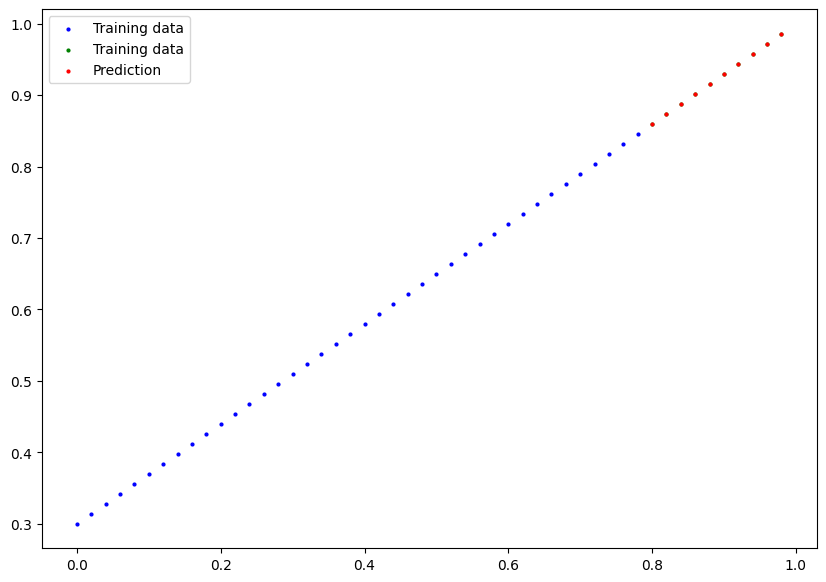

In [20]:
# plot_predictions(predictions = y_preds)    --> won't work since our data on gpu..only works on cpu

# put data on the cpu
plot_predictions(predictions = y_preds.cpu())

In [21]:
# yay!! --> red dots almost prefectly fits with the green dots
# increasing number of epochs helps...

In [23]:
from re import M
# ---SAVING OUT TRAINED MODEL---

from pathlib import Path
# create model directory
model_path = Path('models')
model_path.mkdir(parents = True, exist_ok = True)

# create model save path
model_name = '01_pytorch_model_1.pth'
model_save_path = model_path/model_name

# save the model state_dict
print(f'Saving model to {model_save_path}')
torch.save(obj = model_1.state_dict(),    # saving the state_dict() only saves the model learned paramas
           f = model_save_path)          # not required to save model completely as it may result in inconsistency

Saving model to models/01_pytorch_model_1.pth


In [24]:
# ---LOADING THE SAVED MODEL---
# loading the model into a newly created instance

# instantiate a fresh instance
loaded_model_1 = LinearRegressionModelV2()

# load the model state_dict
loaded_model_1.load_state_dict(torch.load(model_save_path))

# put model to target device
loaded_model_1.to(device)

print(f'Loaded model: \n{loaded_model_1}')
print(f'Model on device: \n{next(loaded_model_1.parameters()).device}')

Loaded model: 
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device: 
cuda:0


<ipython-input-24-e1120165a54f>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(model_save_path))


In [25]:
# evaluate the model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [26]:
# yup!! it workss....